# Figures 3, 7 and 8

## Imports

In [1]:
from brian2 import *
prefs.codegen.target = 'numpy'

import itertools
import numpy as np
import scipy.stats
import matplotlib.cm as cm
from matplotlib.lines import Line2D
import seaborn as sns
import pickle
import glob

from encoder_class.phase_encoder import PhaseEncoder, run_simulation
from encoder_class.theoretical_functions import phi_of_I_lin, phi_of_I, phi_of_I_prime, local_I_from_phi, approx_mutual_I, bins_mutual_I
from encoder_class.encoder_functions import model_sigma, min_phi_distribution, cycle_firing_rate
from encoder_class.plot_functions import plt_fig_3a, plt_fig_3b, plt_fig_3c, plt_fig_3g, plt_fig_3d, plt_fig_3e, plt_fig_3f, plt_fig_3g, plt_fig_7a, plt_fig_7b, plt_fig_7b, plt_fig_8a, plt_fig_8b, plt_fig_8c

In [2]:
num_freqs = 5
num_noises = 5
f_cm = cm.Greens(np.linspace(0, 1, num_freqs))
noise_cm = cm.Blues(np.linspace(0, 1, num_noises))

## Network Setup

In [3]:
M = 5
N = 10

model_params = {}
model_params["tau_m"] = 24*ms
model_params["R_m"] = 142e6*ohm
model_params["v_thres"] = 15*mV
model_params["v_rest"] = 0*mV
model_params["v_reset"] = 0*mV
model_params["tau_ref"] = 0*ms
model_params["v_0"] = 0*mV
model_params["noise_frac"] = 0.05


oscillation_params = {}
oscillation_params["I_osc"] = 40*pA
oscillation_params["f"] = 5*Hz

input_params = {}
input_params["I_min"] = 75*pA
input_params["I_max"] = 130*pA
input_params["corr_frac"] = 0.05
input_params["automatic_range"] = True

simulation_params = {}
simulation_params["method"] = "euler"
simulation_params["num_oscillations"] = 40
simulation_params["monitor_spikes"] = True
simulation_params["monitor_voltage"] = True
simulation_params["dt"] = 0.05*ms
simulation_params["record_dt"] = 0.5*ms

In [4]:
noise_fracs = [0.05, 0.1, 0.2, 0.4]
fs = [1*Hz, 5*Hz, 15*Hz, 30*Hz]

## Run Grid Experiments

In [5]:
'''
#to create your own data:


experiments = itertools.product(noise_fracs, fs)
num_experiments = len(list(experiments))
experiments = itertools.product(noise_fracs, fs)

all_fs = []
all_stoch_sigmas = []
distribution_params = []
exp_all_phis = []



for experiment, (noise_frac, f) in enumerate(experiments):
    model_params["noise_frac"] = noise_frac
    oscillation_params["f"] = f
    encoder = PhaseEncoder(num_ensembles=M, ensemble_size=N, model_params=model_params, 
                       oscillation_params=oscillation_params, input_params=input_params,
                       simulation_params=simulation_params, rnd_seed=0)
    if experiment%100==0:
        print("{} experiments completed out of {}".format(experiment, num_experiments))
        
    all_fs.append(f)
    all_stoch_sigmas.append(model_sigma(noise_frac, encoder))

    phis = run_simulation(encoder, mode='experimental')
    exp_all_phis.append(phis)
        
    mus, i_sigmas, phi_sigmas  = get_distr_params(encoder)
    distribution_params.append((mus, phi_sigmas))

print("{} experiments completed out of {}".format(experiment+1, num_experiments))

filename = 'Figures/' + 'grid' + ".pickle"

results_dict = {}
results_dict["all_fs"] = all_fs
results_dict["all_stoch_sigmas"] = all_stoch_sigmas
results_dict["exp_all_phis"] = exp_all_phis
results_dict["distribution_params"] = distribution_params

with open(filename, 'wb') as handle:
    pickle.dump(results_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
'''

'\n#to create your own data:\n\n\nexperiments = itertools.product(noise_fracs, fs)\nnum_experiments = len(list(experiments))\nexperiments = itertools.product(noise_fracs, fs)\n\nall_fs = []\nall_stoch_sigmas = []\ndistribution_params = []\nexp_all_phis = []\n\n\n\nfor experiment, (noise_frac, f) in enumerate(experiments):\n    model_params["noise_frac"] = noise_frac\n    oscillation_params["f"] = f\n    encoder = PhaseEncoder(num_ensembles=M, ensemble_size=N, model_params=model_params, \n                       oscillation_params=oscillation_params, input_params=input_params,\n                       simulation_params=simulation_params, rnd_seed=0)\n    if experiment%100==0:\n        print("{} experiments completed out of {}".format(experiment, num_experiments))\n        \n    all_fs.append(f)\n    all_stoch_sigmas.append(model_sigma(noise_frac, encoder))\n\n    phis = run_simulation(encoder, mode=\'experimental\')\n    exp_all_phis.append(phis)\n        \n    mus, i_sigmas, phi_sigmas  

## Save / Load Data

In [6]:
filename = 'Figures/' + 'grid' + ".pickle"

with open(filename, 'rb') as handle:
    results_dict = pickle.load(handle)
    
all_fs = results_dict["all_fs"]
all_stoch_sigmas = results_dict["all_stoch_sigmas"]
exp_all_phis = results_dict["exp_all_phis"] 
distribution_params = results_dict["distribution_params"]

## Figure 3A

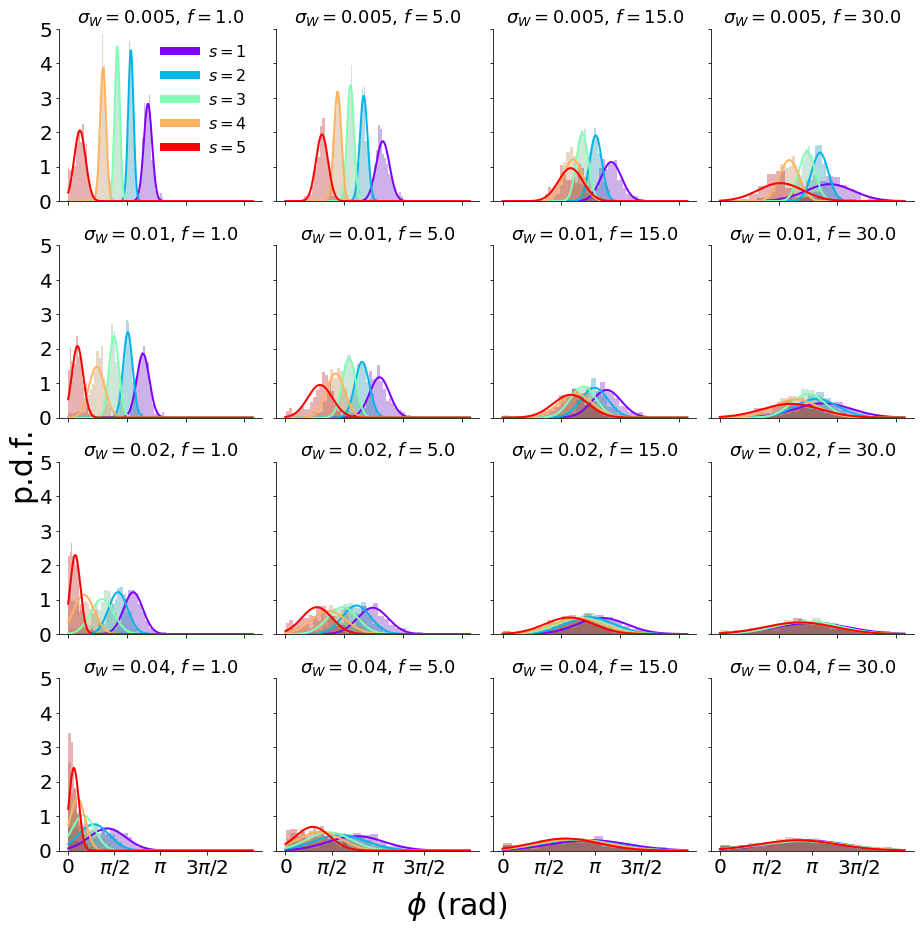

In [7]:
plt.rcParams['figure.figsize'] = [13, 13]
fig, axs = plt.subplots(4, 4)
c = cm.rainbow(np.linspace(0, 1, M))
x_values = np.arange(0, 2*pi, 0.01)

for experiment, (ax, exp_phis, params) in enumerate(zip(fig.get_axes(), exp_all_phis, distribution_params)):
    
    sigma_str = str(eval("%.0e" % (all_stoch_sigmas[experiment]*np.sqrt(second)/volt)))
    f_str = str(all_fs[experiment]/Hz)
    title = r"$\sigma_W = $" + sigma_str + r", $f = $" + f_str
    ax.set_title(title, fontsize=18)
    
    for neuron_type in range(M):
        phi_mean_exp = np.mean(exp_phis[neuron_type])
        phi_std_exp = np.std(exp_phis[neuron_type])

        y_values_exp = scipy.stats.norm(phi_mean_exp, phi_std_exp)
        ax.set_ylim([0, 5])
        ax.plot(x_values, y_values_exp.pdf(x_values), color=c[neuron_type], linewidth=2)
        
    for neuron_type in range(M):
        n, bins, pathces = ax.hist(exp_phis[neuron_type],label=r's = %.0f'%neuron_type, bins=20, density=True, color=0.7*c[neuron_type], alpha=0.3)
        

plt_fig_3a(c, M, fig, axs)

fig.savefig('Figures/Figure_3a.svg', dpi=600)
fig.savefig('Figures/Figure_3a.png', dpi=600)

## Run Experiments (Frequency Profiles)

In [8]:
noise_fracs = [0.05, 0.1, 0.2, 0.4]
fs = np.linspace(1*Hz, 50*Hz, 50)

encoder = PhaseEncoder(num_ensembles=M, ensemble_size=N, model_params=model_params, 
                       oscillation_params=oscillation_params, input_params=input_params,
                       simulation_params=simulation_params, rnd_seed=0)

stoch_sigmas = np.array(list(map(lambda eta: model_sigma(eta, encoder), noise_fracs)))

In [9]:
'''

#to create your own data:


experiments = itertools.product(noise_fracs, fs)
num_experiments = len(list(experiments))
experiments = itertools.product(noise_fracs, fs)

#keep params for plots
all_fs = []
all_stoch_sigmas = []
#keep exp values of I_eff
all_I_effs = []
all_exp_mus_I = []
all_exp_sigmas_I = []
#keep exp values of phi
all_exp_phis = []
#keep derivatives
all_ders = []



for experiment, (noise_frac, f) in enumerate(experiments):
    model_params["noise_frac"] = noise_frac
    oscillation_params["f"] = f
    encoder = PhaseEncoder(num_ensembles=M, ensemble_size=N, model_params=model_params, 
                       oscillation_params=oscillation_params, input_params=input_params,
                       simulation_params=simulation_params, rnd_seed=0)
    if experiment%100==0:
        print("{} experiments completed out of {}".format(experiment, num_experiments))
        
    all_fs.append(f)
    all_stoch_sigmas.append(model_sigma(noise_frac, encoder))

    
    #exp phis
    exp_phis = run_simulation(encoder, mode='experimental')
    all_exp_phis.append(exp_phis)
    
    #exp I_eff
    I_effs = []
    mus_I = []
    sigmas_I = []
    I_s = list(map(lambda s : encoder.input_params["I_s"][s*N], np.arange(M)))
    ders = phi_of_I_prime(encoder, I_s)
    all_ders.append(ders)
    
    all_th_mus_I.append(I_s)
    for i_s, phis in zip(I_s, exp_phis):
        I_eff = local_I_from_phi(encoder, i_s, phis)
        mu_I = np.mean(I_eff)
        sigma_I = np.std(I_eff)
        I_effs.append(I_eff)
        mus_I.append(mu_I)
        sigmas_I.append(sigma_I)
        
    all_I_effs.append(I_effs)
    all_exp_mus_I.append(mus_I)
    all_exp_sigmas_I.append(sigmas_I)
    

print("{} experiments completed out of {}".format(experiment+1, num_experiments))


filename = 'Figures/' + 'I_eff_f' + ".pickle"

results_dict = {}
results_dict["all_fs"] = all_fs
results_dict["all_stoch_sigmas"] = all_stoch_sigmas
results_dict["all_I_effs"] = all_I_effs
results_dict["all_exp_mus_I"] = all_exp_mus_I
results_dict["all_exp_sigmas_I"] = all_exp_sigmas_I
results_dict["all_exp_phis"] = all_exp_phis
results_dict["all_ders"] = all_ders

with open(filename, 'wb') as handle:
    pickle.dump(results_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
'''

'\n\n#to create your own data:\n\n\nexperiments = itertools.product(noise_fracs, fs)\nnum_experiments = len(list(experiments))\nexperiments = itertools.product(noise_fracs, fs)\n\n#keep params for plots\nall_fs = []\nall_stoch_sigmas = []\n#keep exp values of I_eff\nall_I_effs = []\nall_exp_mus_I = []\nall_exp_sigmas_I = []\n#keep exp values of phi\nall_exp_phis = []\n#keep derivatives\nall_ders = []\n\n\n\nfor experiment, (noise_frac, f) in enumerate(experiments):\n    model_params["noise_frac"] = noise_frac\n    oscillation_params["f"] = f\n    encoder = PhaseEncoder(num_ensembles=M, ensemble_size=N, model_params=model_params, \n                       oscillation_params=oscillation_params, input_params=input_params,\n                       simulation_params=simulation_params, rnd_seed=0)\n    if experiment%100==0:\n        print("{} experiments completed out of {}".format(experiment, num_experiments))\n        \n    all_fs.append(f)\n    all_stoch_sigmas.append(model_sigma(noise_frac

In [10]:
filename = 'Figures/' + 'I_eff_f' + ".pickle"

with open(filename, 'rb') as handle:
    results_dict = pickle.load(handle)
    
all_fs = results_dict["all_fs"]
all_stoch_sigmas = results_dict["all_stoch_sigmas"] 
all_I_effs = results_dict["all_I_effs"]
all_exp_mus_I = results_dict["all_exp_mus_I"] 
all_exp_sigmas_I = results_dict["all_exp_sigmas_I"]
all_exp_phis = results_dict["all_exp_phis"] 
all_th_mus_I = results_dict["all_th_mus_I"]
all_th_sigmas_I = results_dict["all_th_sigmas_I"]
all_ders = results_dict["all_ders"]

## Figure 7A

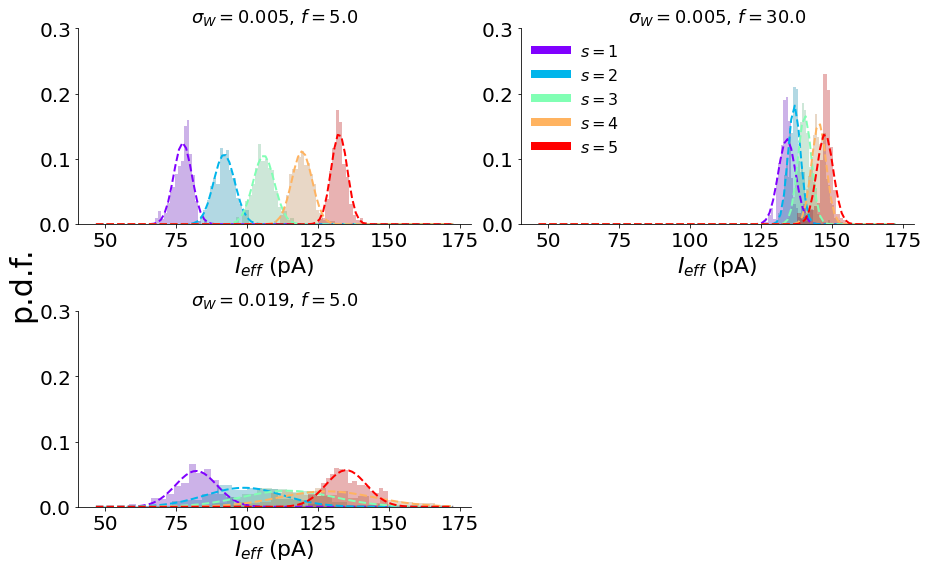

In [11]:
sample = [4, 29, 104]
sample_I_effs = [all_I_effs[i]/pA for i in sample]
sample_mus = [all_exp_mus_I[i]/pA for i in sample]
sample_sigmas = [all_exp_sigmas_I[i]/pA for i in sample]
sample_fs = [all_fs[i] for i in sample]
sample_stoch_sigmas = [all_stoch_sigmas[i] for i in sample]


plt.rcParams['figure.figsize'] = [13, 8]
fig, axs = plt.subplots(2, 2)
c = cm.rainbow(np.linspace(0, 1, M))

x_min = min([min(I_eff) for I_effs in sample_I_effs for I_eff in I_effs])
x_max = max([max(I_eff) for I_effs in sample_I_effs for I_eff in I_effs])
x_values = np.linspace(x_min, x_max, 100)


for experiment, (ax, I_effs, mus, sigmas, stoch_sigma) in enumerate(zip(fig.get_axes(), sample_I_effs, sample_mus, sample_sigmas, sample_stoch_sigmas)):

    sigma_str = r"$\sigma_W = $" + str(round(stoch_sigma, 3))[:5] 
    f_str = str(sample_fs[experiment]/Hz)
    title = sigma_str + r", $f = $" + f_str
    ax.set_title(title, fontsize=18)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.set_yticks([0, 0.1, 0.2, 0.3])
    ax.set_ylim([0, 0.3])
    ax.set_xlabel(r"$I_{eff}$ (pA)", fontsize=22)
    
    for neuron_type in range(M):
        n, bins, pathces = ax.hist(I_effs[neuron_type], bins=20, density=True, color=0.7*c[neuron_type], alpha=0.3)

    for neuron_type in range(M):
        I_mean = mus[neuron_type]
        I_std = sigmas[neuron_type]

        y_values_th = scipy.stats.norm(I_mean, I_std)
        ax.plot(x_values, y_values_th.pdf(x_values), color=c[neuron_type],linestyle='dashed', linewidth=2)

plt_fig_7a(c, M, fig, axs)

fig.savefig('Figures/Figure_7a.svg', dpi=600)
fig.savefig('Figures/Figure_7a.png', dpi=600)

In [12]:
all_exp_sigmas_I = np.array(all_exp_sigmas_I).reshape((4, 50, 5))
all_exp_mus_I = np.array(all_exp_mus_I).reshape((4, 50, 5))
all_th_sigmas_I = np.array(all_th_sigmas_I).reshape((4, 50))
all_th_mus_I = np.array(all_th_mus_I).reshape((4, 50, 5))
all_I_effs = np.array(all_I_effs, dtype=object).reshape((4, 50, 5))
all_ders =  np.array(all_ders, dtype=object).reshape((4, 50, 5))
exp_phis_std = np.zeros((4, 50, 5))
for noise in range(4):
    for f in range(50):
        index = noise*50 + f
        exp_phis_std[noise][f] = np.std(all_exp_phis[index], axis=1)

## Figure 3B

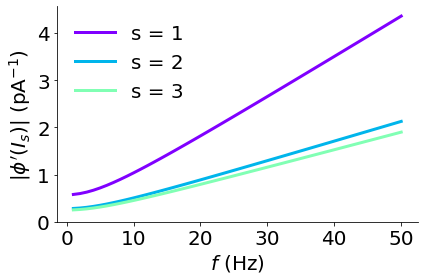

In [13]:
plt.rcParams['figure.figsize'] = [6.0, 4.0]
for s in range(M//2 + 1):
    plt.plot(fs, np.abs(all_ders[0, :, s])/1e11, color=c[s], label=r's = %.0f'%(s+1),linewidth=3)

plt_fig_3b()
plt.savefig('Figures/Figure_3b.svg', dpi=600)
plt.savefig('Figures/Figure_3b.png', dpi=600)

## Figure 3C

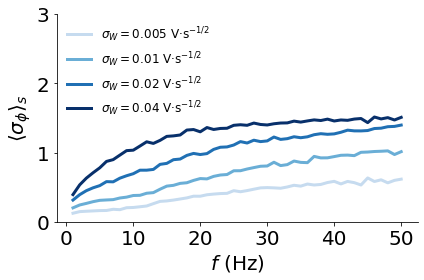

In [14]:
plt.rcParams['figure.figsize'] = [6.0, 4.0]
for i, stoch_sigma in enumerate(stoch_sigmas):
    
    noise_label = r"$\sigma_W = $" + str(eval("%.0e" % (stoch_sigma))) + r" V·s$^{-1/2}$"
    plt.plot(fs, np.mean(exp_phis_std[i, :, :], axis=1), color= noise_cm[i + 1],label=noise_label, linewidth=3)

plt_fig_3c()
plt.savefig('Figures/Figure_3c.svg', dpi=600)
plt.savefig('Figures/Figure_3c.png', dpi=600)

## Figure 7B

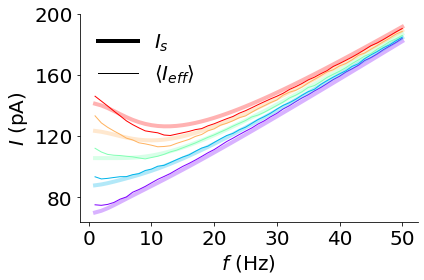

In [15]:
noise_level = 1
plt.rcParams['figure.figsize'] = [6.0, 4.0]

for s in range(5):
    plt.plot(fs, all_exp_mus_I[noise_level, :, s]/pA, linewidth=1, color=c[s])
    plt.plot(fs, all_th_mus_I[noise_level, :, s]/pA, linewidth=4, color=c[s], alpha=0.3)
    
plt_fig_7b()

plt.savefig('Figures/Figure_7b.svg', dpi=600)
plt.savefig('Figures/Figure_7b.png', dpi=600)

## Figure 8A

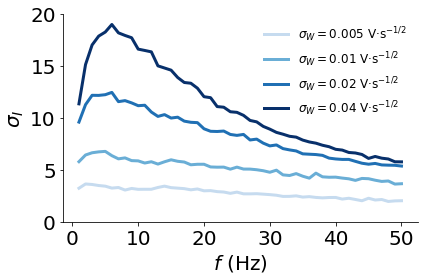

In [16]:
 for i, stoch_sigma in enumerate(stoch_sigmas):
        noise_label = r"$\sigma_W = $" + str(eval("%.0e" % (stoch_sigma))) + r" V·s$^{-1/2}$"
        plt.plot(fs, np.mean(all_exp_sigmas_I[i, :]/pA, axis=1), color= noise_cm[i + 1], label=noise_label, linewidth=3)

plt_fig_8a()
plt.savefig('Figures/Figure_8a.svg', dpi=600)
plt.savefig('Figures/Figure_8a.png', dpi=600)

## Run Experiments (Noise Profile)

In [17]:
noise_fracs = np.linspace(0, 0.4, 50)
fs = [1*Hz, 5*Hz, 15*Hz, 30*Hz]

encoder = PhaseEncoder(num_ensembles=M, ensemble_size=N, model_params=model_params, 
                       oscillation_params=oscillation_params, input_params=input_params,
                       simulation_params=simulation_params, rnd_seed=0)

stoch_sigmas = np.array(list(map(lambda eta: model_sigma(eta, encoder), noise_fracs)))

In [18]:
'''
#to create your own data

experiments = itertools.product(noise_fracs, fs)
num_experiments = len(list(experiments))
experiments = itertools.product(noise_fracs, fs)

#keep params for plots
all_fs = []
all_stoch_sigmas = []
#keep exp values of I_eff
all_I_effs = []
all_exp_mus_I = []
all_exp_sigmas_I = []
#keep exp values of phi
all_exp_phis = []
#keep th values
all_th_mus_I = []
all_th_sigmas_I = []
all_ders = []



for experiment, (noise_frac, f) in enumerate(experiments):
    model_params["noise_frac"] = noise_frac
    oscillation_params["f"] = f
    encoder = PhaseEncoder(num_ensembles=M, ensemble_size=N, model_params=model_params, 
                       oscillation_params=oscillation_params, input_params=input_params,
                       simulation_params=simulation_params, rnd_seed=0)
    if experiment%100==0:
        print("{} experiments completed out of {}".format(experiment, num_experiments))
        
    all_fs.append(f)
    all_stoch_sigmas.append(model_sigma(noise_frac, encoder))
    
    
    #exp phis
    exp_phis = run_simulation(encoder, mode='experimental')
    all_exp_phis.append(exp_phis)
    
    #exp I_eff
    I_effs = []
    mus_I = []
    sigmas_I = []
    I_s = list(map(lambda s : encoder.input_params["I_s"][s*N], np.arange(M)))
    all_th_mus_I.append(I_s)
    for i_s, phis in zip(I_s, exp_phis):
        I_eff = local_I_from_phi(encoder, i_s, phis)
        mu_I = np.mean(I_eff)
        sigma_I = np.std(I_eff)
        I_effs.append(I_eff)
        mus_I.append(mu_I)
        sigmas_I.append(sigma_I)
        
    all_I_effs.append(I_effs)
    all_exp_mus_I.append(mus_I)
    all_exp_sigmas_I.append(sigmas_I)
    

print("{} experiments completed out of {}".format(experiment+1, num_experiments))


filename = 'Figures/' + 'I_eff_noise' + ".pickle"
results_dict = {}
results_dict["all_fs"] = all_fs
results_dict["all_stoch_sigmas"] = all_stoch_sigmas
results_dict["all_I_effs"] = all_I_effs
results_dict["all_exp_mus_I"] = all_exp_mus_I
results_dict["all_exp_sigmas_I"] = all_exp_sigmas_I
results_dict["all_exp_phis"] = all_exp_phis
results_dict["all_th_sigmas_I"] = all_th_sigmas_I
results_dict["all_ders"] = all_ders
with open(filename, 'wb') as handle:
    pickle.dump(results_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
'''

'\n#to create your own data\n\nexperiments = itertools.product(noise_fracs, fs)\nnum_experiments = len(list(experiments))\nexperiments = itertools.product(noise_fracs, fs)\n\n#keep params for plots\nall_fs = []\nall_stoch_sigmas = []\n#keep exp values of I_eff\nall_I_effs = []\nall_exp_mus_I = []\nall_exp_sigmas_I = []\n#keep exp values of phi\nall_exp_phis = []\n#keep th values\nall_th_mus_I = []\nall_th_sigmas_I = []\nall_ders = []\n\n\n\nfor experiment, (noise_frac, f) in enumerate(experiments):\n    model_params["noise_frac"] = noise_frac\n    oscillation_params["f"] = f\n    encoder = PhaseEncoder(num_ensembles=M, ensemble_size=N, model_params=model_params, \n                       oscillation_params=oscillation_params, input_params=input_params,\n                       simulation_params=simulation_params, rnd_seed=0)\n    if experiment%100==0:\n        print("{} experiments completed out of {}".format(experiment, num_experiments))\n        \n    all_fs.append(f)\n    all_stoch_si

In [19]:
filename = 'Figures/' + 'I_eff_noise' + ".pickle"


with open(filename, 'rb') as handle:
    results_dict = pickle.load(handle)
    
all_fs = results_dict["all_fs"]
all_stoch_sigmas = results_dict["all_stoch_sigmas"] 
all_I_effs = results_dict["all_I_effs"]
all_exp_mus_I = results_dict["all_exp_mus_I"] 
all_exp_sigmas_I = results_dict["all_exp_sigmas_I"]
all_exp_phis = results_dict["all_exp_phis"] 
all_th_sigmas_I = results_dict["all_th_sigmas_I"] 
all_ders = results_dict["all_ders"]

In [20]:
all_exp_sigmas_I = np.array(all_exp_sigmas_I).reshape((50, 4, 5))
all_exp_mus_I = np.array(all_exp_mus_I).reshape((50, 4, 5))
all_th_sigmas_I = np.array(all_th_sigmas_I).reshape((50, 4))
all_I_effs = np.array(all_I_effs, dtype=object).reshape((50, 4, 5))
all_ders =  np.array(all_ders, dtype=object).reshape((50, 4, 5))
exp_phis_std = np.zeros((50, 4, 5))
for noise in range(50):
    for f in range(4):
        index = noise*4 + f
        exp_phis_std[noise][f] = np.std(all_exp_phis[index], axis=1)

## Figure 3D

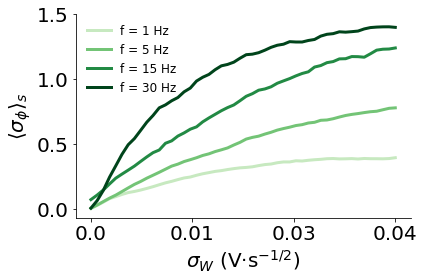

In [21]:
for i, f in enumerate(fs):
        plt.plot(stoch_sigmas, np.mean(exp_phis_std[:, i, :], axis=1), color = f_cm[i + 1], label=r'f = %.0f Hz'%f, linewidth=3)

plt_fig_3d(stoch_sigmas)
plt.savefig('Figures/Figure_3d.svg', dpi=600)
plt.savefig('Figures/Figure_3d.png', dpi=600)

## Figure 8B

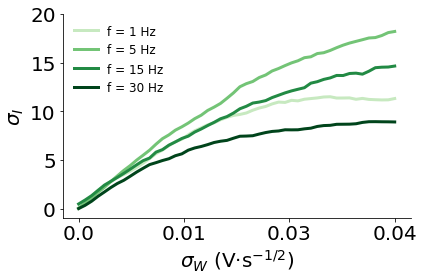

In [22]:
for i, f in enumerate(fs):
        plt.plot(stoch_sigmas, np.mean(all_exp_sigmas_I[:, i]/pA, axis=1), color=f_cm[i + 1], label=r'f = %.0f Hz'%f, linewidth=3)

plt_fig_8b(stoch_sigmas)

plt.savefig('Figures/Figure_8b.svg', dpi=600)
plt.savefig('Figures/Figure_8b.png', dpi=600)

## Load and Process Data (Mutual Information)

In [23]:
partition = 100
noise_lims = [0., 0.4]
f_lims = [1*Hz, 50*Hz]
noise_fracs = np.linspace(noise_lims[0], noise_lims[1], partition)
fs = np.linspace(f_lims[0], f_lims[1], partition)
stoch_sigmas = np.array(list(map(lambda eta: model_sigma(eta, encoder), noise_fracs)))

exp_MI_matrix = []
files = [file for file in sorted(glob.glob('cluster_sims/Data_Noise/*.pickle'))]

for filename in files:
    with open(filename, 'rb') as handle:
        result = pickle.load(handle)
        exp_MI_matrix.append(result['MI'])
exp_MI_matrix = np.reshape(exp_MI_matrix, (partition, partition))
exp_MI_matrix = np.log2(np.exp(1))*exp_MI_matrix

## Figure 3E

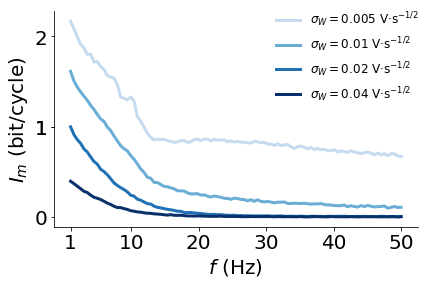

In [24]:
plt.rcParams['figure.figsize'] = [6.0, 4.0]
fig, ax1 = plt.subplots()

ax1_color = 'black'
style = ["dotted", "dashed", "solid", "solid"]
for i, index in enumerate([13, 26, 52, 99]):
    noise_label = r"$\sigma_W = $" + str(eval("%.0e" % (stoch_sigmas[index]))) + r" V·s$^{-1/2}$"
    ax1.plot(fs, exp_MI_matrix[index,:], label=noise_label, color=noise_cm[i + 1], linewidth=3)

plt_fig_3e(fs, fig, ax1)
fig.savefig('Figures/Figure_3e.svg', dpi=600)
fig.savefig('Figures/Figure_3e.png', dpi=600)

## Figure 3F

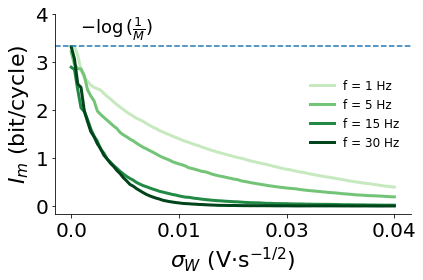

In [25]:
for i, index in enumerate([0, 9, 29, 58]):
    plt.plot(stoch_sigmas, exp_MI_matrix[:, index], label=r'f = %.0f Hz'%fs[index], color=f_cm[i + 1], linewidth=3)

plt_fig_3f(stoch_sigmas)
plt.savefig('Figures/Figure_3f.svg', dpi=600)
plt.savefig('Figures/Figure_3f.png', dpi=600)

## Figure 3G

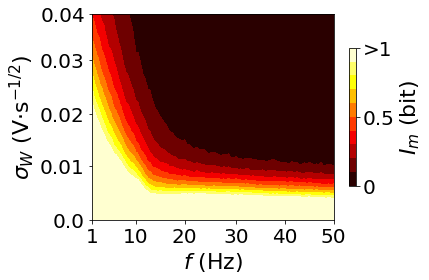

In [26]:
plt.figure(figsize=(6,4))

plt.contourf(np.clip(exp_MI_matrix, 0, 1), cmap='hot', vmin=0,levels=10)

plt_fig_3g(fs, stoch_sigmas)
plt.savefig('Figures/Figure_3g.svg', dpi=600)
plt.savefig('Figures/Figure_3g.png', dpi=600)
plt.show()

## Run Experiments (Spikes/Cycle)

In [27]:
noise_fracs = [0.0, 0.05, 0.1, 0.2, 0.4]
fs = np.linspace(1*Hz, 50*Hz, 50)

encoder = PhaseEncoder(num_ensembles=M, ensemble_size=N, model_params=model_params, 
                       oscillation_params=oscillation_params, input_params=input_params,
                       simulation_params=simulation_params, rnd_seed=0)

stoch_sigmas = np.array(list(map(lambda eta: model_sigma(eta, encoder), noise_fracs)))

In [28]:
'''to create your own data

experiments = itertools.product(noise_fracs, fs)
num_experiments = len(list(experiments))
experiments = itertools.product(noise_fracs, fs)

#keep params for plots
all_fs = []
all_stoch_sigmas = []
#keep exp values of I_eff
all_CFRs = []



for experiment, (noise_frac, f) in enumerate(experiments):
    model_params["noise_frac"] = noise_frac
    oscillation_params["f"] = f
    encoder = PhaseEncoder(num_ensembles=M, ensemble_size=N, model_params=model_params, 
                       oscillation_params=oscillation_params, input_params=input_params,
                       simulation_params=simulation_params, rnd_seed=0)
    if experiment%100==0:
        print("{} experiments completed out of {}".format(experiment, num_experiments))
        
    all_fs.append(f)
    all_stoch_sigmas.append(model_sigma(noise_frac, encoder))
    run_simulation(encoder, mode='None')
    CFR = cycle_firing_rate(encoder.monitors["SM"], simulation_params["num_oscillations"], M, N)
    all_CFRs.append(CFR)
    

print("{} experiments completed out of {}".format(experiment+1, num_experiments))


filename = 'Figures/' + 'CFRs_f' + ".pickle"
results_dict = {}
results_dict["all_CFRs"] = all_CFRs
with open(filename, 'wb') as handle:
    pickle.dump(results_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

'''

'to create your own data\n\nexperiments = itertools.product(noise_fracs, fs)\nnum_experiments = len(list(experiments))\nexperiments = itertools.product(noise_fracs, fs)\n\n#keep params for plots\nall_fs = []\nall_stoch_sigmas = []\n#keep exp values of I_eff\nall_CFRs = []\n\n\n\nfor experiment, (noise_frac, f) in enumerate(experiments):\n    model_params["noise_frac"] = noise_frac\n    oscillation_params["f"] = f\n    encoder = PhaseEncoder(num_ensembles=M, ensemble_size=N, model_params=model_params, \n                       oscillation_params=oscillation_params, input_params=input_params,\n                       simulation_params=simulation_params, rnd_seed=0)\n    if experiment%100==0:\n        print("{} experiments completed out of {}".format(experiment, num_experiments))\n        \n    all_fs.append(f)\n    all_stoch_sigmas.append(model_sigma(noise_frac, encoder))\n    run_simulation(encoder, mode=\'None\')\n    CFR = cycle_firing_rate(encoder.monitors["SM"], simulation_params["num

In [29]:
filename = 'Figures/' + 'CFRs_f' + ".pickle"
with open(filename, 'rb') as handle:
    results_dict = pickle.load(handle)
    
all_CFRs = results_dict["all_CFRs"] 
all_CFRs =  np.array(all_CFRs).reshape((5, 50, 5))

## Figure 8C

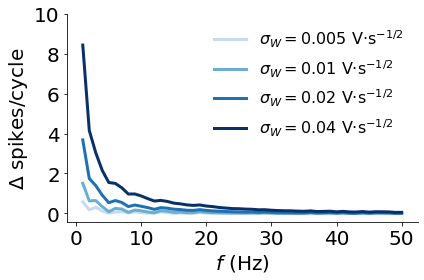

In [30]:
for i, stoch_sigma in enumerate(stoch_sigmas):
    if i != 0:
        noise_label = r"$\sigma_W = $" + str(eval("%.0e" % (stoch_sigma))) + r" V·s$^{-1/2}$"
        plt.plot(fs, np.abs(np.mean(all_CFRs[0,:,:] - all_CFRs[i,:,:], axis=1)), label=noise_label, color=noise_cm[i], linewidth=3)

plt_fig_8c()
plt.savefig('Figures/Figure_8c.svg', dpi=600)
plt.savefig('Figures/Figure_8c.png', dpi=600)
plt.show()